## Imports: standard libraries, data processing, visualization, ML/DL


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, classification_report, silhouette_score
from sklearn.model_selection import learning_curve, train_test_split
from scipy.stats import normaltest
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas_ta_classic as ta
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from fredapi import Fred
# %matplotlib inline

In [ ]:
#Run to get interactive plots
%matplotlib notebook

## Configure API Keys

Set up any external data APIs such as FRED for macroeconomic features

In [2]:
#Setup my Fred API
fred = Fred(api_key="enter your personal API here")  #

## Data Acquisition and Feature Engineering

Download historical stock and index price data, generate key financial indicators (momentum, volatility, technicals), and, if enabled, merge macroeconomic features


In [2]:
def download_stock_data(ticker, start_date, end_date):
    """Download historical price data for a given ticker."""
    try:
        df = yf.download(ticker, start=start_date, end=end_date)
        df.dropna(inplace=True)
        return df
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return pd.DataFrame()

def create_features(df, ticker_target, ticker_feature):
    df_target = df.xs(ticker_target, axis=1, level=1)
    df_feature = df.xs(ticker_feature, axis=1, level=1)
    ##Create "self" features with the target ticker
    df_target['Return'] = df_target['Close'].pct_change().dropna()
    # df['Log_Return'] = np.log1p(df['Close'].pct_change())
    df_target['Lag1'] = df_target['Return'].shift(1)
    df_target['Lag2'] = df_target['Return'].shift(2)
    df_target['Lag3'] = df_target['Return'].shift(3)    
    # Moving averages
    df_target['MA_5'] = df_target['Close'].rolling(window=5).mean()
    df_target['MA_10'] = df_target['Close'].rolling(window=10).mean()
    df_target['Momentum'] = df_target['MA_5'] - df_target['MA_10']    
    #volatility
    df_target['Volatility'] = df_target['Return'].rolling(window=10).std()
    #more advanced built-in indicators
    df_target.ta.rsi(length=14, append=True)
    df_target.ta.macd(append=True)
    df_target.ta.bbands(length=20, std=2, append=True)
    df_target.ta.atr(length=14, append=True)
    df_target.ta.obv(append=True)
    df_target.ta.sma(length=20, append=True)
    df_target.ta.ema(length=50, append=True)

    ##Create features with the feature ticker

    df_feature[f"{ticker_feature}_Close"] = df_feature["Close"]
    df_feature[f"{ticker_feature}_Return_lag1"] = df_feature["Close"].pct_change().shift(1)

    
    df = pd.concat([df_target, df_feature], axis=1)
    df = df.dropna()

    ##Optionally include macro economic factors
    # macros = pd.DataFrame({
    #      'CPI_Inflation': fred.get_series("CPIAUCSL"),
    #      'Interest_Rate': fred.get_series("FEDFUNDS"),
    #      'GDP': fred.get_series('GDP')}).resample('B').ffill()

# Combine the macro features to the primary features
# df = df.merge(macros, left_index=True, right_index=True)
    
    # Fix potential MultiIndex columns
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df

def select_features(df, ticker):
    """Prepare feature matrix for modeling."""
    features = df[ticker].dropna()
    return features


start_date = '2020-01-01'
end_date = '2025-01-01'
ticker = ["MSFT", "^GSPC"]
ticker_target, ticker_feature = "MSFT", "^GSPC"
selected_tickers = [f"{ticker_feature}_Return_lag1", f"{ticker_feature}_Close", "Volatility", "MA_5", "MA_10", "RSI_14", "MACD_12_26_9", "OBV", "Volume"]

In [3]:
raw_data = download_stock_data(ticker, start_date, end_date)
engineered_data = create_features(raw_data, ticker_target, ticker_feature)
x, y = select_features(engineered_data, selected_tickers), engineered_data["Return"]

/tmp/ipykernel_2821879/173752736.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  2 of 2 completed
/tmp/ipykernel_2821879/173752736.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['Return'] = df_target['Close'].pct_change().dropna()
/tmp/ipykernel_2821879/173752736.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['Lag1'] = df_target['R

## Gaussian Process Regression Model & Principal Component Analysis

Fits a Gaussian Process regression model to the input features and target returns. The kernel combines constant, RBF, and white noise components for robust time series modeling.

Applies PCA to technical, macro, and market features to reduce dimensionality before fitting GP regression. 


In [4]:
def preprocess_data(x,y):
    # Train-test split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=False)
    
    # Scale features
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)   

    return x_train_scaled, x_test_scaled, y_train, y_test

def gp_regressor(x_train, y_train):
    
    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.01)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
    gp.fit(x_train, y_train)
    return gp

def gp_pca_regressor(x_train, y_train, n_components=5):
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_test_scaled = scaler.transform(X_test)
    pca = PCA(n_components=n_components)
    x_train_pca = pca.fit_transform(x_train_scaled)
    x_test_pca = pca.transform(x_test_scaled)
    
    gp_pca = gp_regressor(x_train_pca, y_train)
    return gp_pca, x_train_pca, x_test_pca

    

x_train_scaled, x_test_scaled, y_train, y_test = preprocess_data(x,y)
gp = gp_regressor(x_train_scaled, y_train)
gp_pca, x_train_pca, x_test_pca = gp_pca_regressor(x_train_scaled, y_train)

/home/devanshu/jupyter_env/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


## Model Evaluation and Comparison

In [5]:
def evaluate_model(model, x_test, y_test):
    """
    Evaluate model predictions using MSE and R2.
    Returns metrics and predictions.
    """
    y_pred, y_std = model.predict(x_test, return_std=True)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    residuals = y_test - y_pred
    # mae = mean_absolute_error(y_test, y_pred)
    return y_pred, y_std, mse, r2, residuals

y_pred_gp, y_std_gp, mse_gp, r2_gp, residuals_gp = evaluate_model(gp, x_test_scaled, y_test)
print("The metrics for GP based model")
print(f"MSE: {mse_gp:.4f}, R2: {r2_gp:.4f}\n")

y_pred_pca, y_std_pca, mse_pca, r2_pca, residuals_pca = evaluate_model(gp_pca, x_test_pca, y_test)
print("The metrics for GP+PCA based model")
print(f"MSE: {mse_pca:.4f}, R2: {r2_pca:.4f}")

The metrics for GP based model
MSE: 0.0002, R2: -0.5240

The metrics for GP+PCA based model
MSE: 0.0002, R2: -0.1947


## Visuals of the predicted returns

Predictions & Residuals for GP based model:



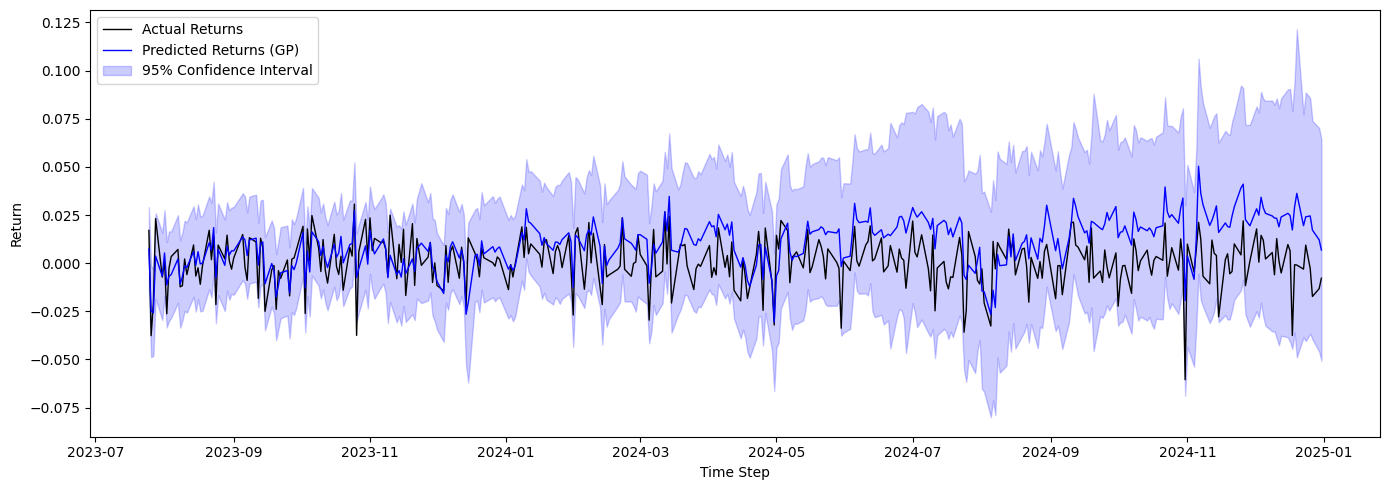

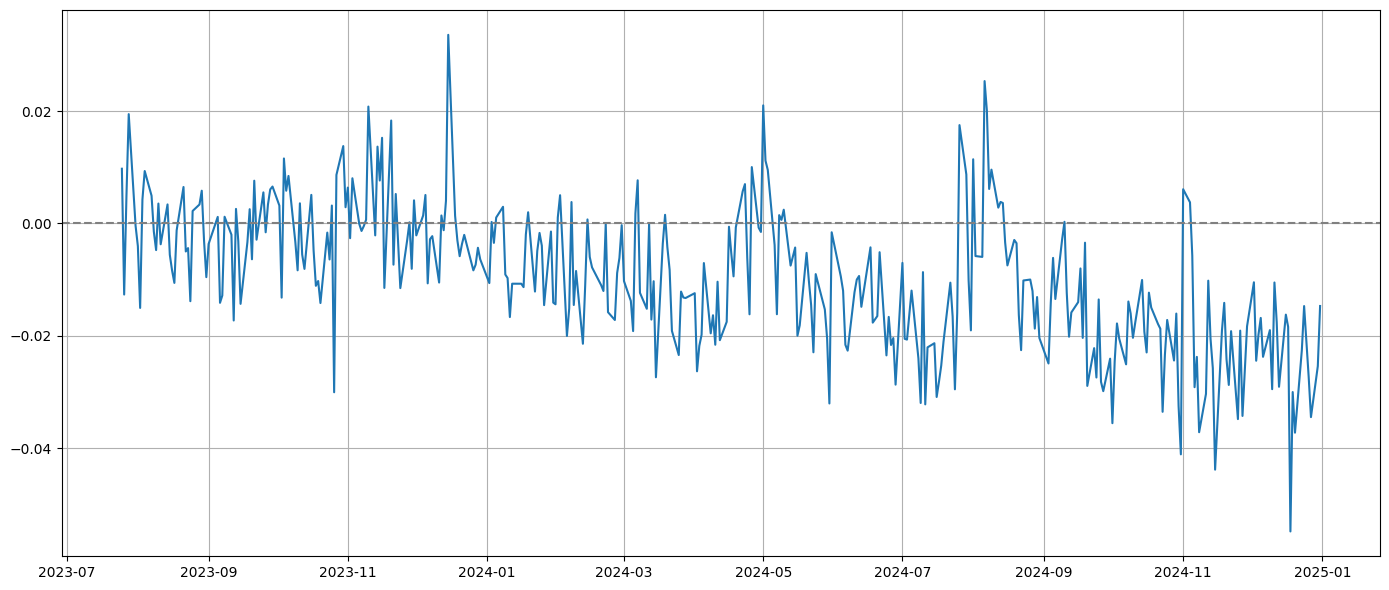

In [20]:
def plot_predictions(y_true, y_pred, y_std): #title="GP Regression: Predicted vs Actual Returns"

    plt.figure(figsize=(14, 5))
    plt.plot(y_true.index.to_numpy(), y_true.values, label="Actual Returns", color="black", linewidth=1)
    plt.plot(y_true.index.to_numpy(), y_pred, label="Predicted Returns (GP)", color="blue", linewidth=1)
    plt.fill_between(
        y_test.index.to_numpy(),
        y_pred - 2 * y_std,
        y_pred + 2 * y_std,
        color="blue",
        alpha=0.2,
        label="95% Confidence Interval"
    )
    plt.legend()
    # plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Return")
    plt.tight_layout()
    plt.show()

def plot_residuals(y_test, residuals):
    plt.figure(figsize=(14,6))
    plt.plot(y_test.index.to_numpy(), residuals, label="Residuals")
    plt.axhline(0, linestyle='--', color='gray')
    # plt.title("Residuals of GP Predictions")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



print("Predictions & Residuals for GP based model:\n")
plot_predictions(y_test, y_pred_gp, y_std_gp)
plot_residuals(y_test, residuals_gp)

# print("Predictions & Residuals for GP+PCA based model:\n")
# plot_predictions(y_test, y_pred_pca, y_std_pca)
# plot_residuals(y_test, residuals_pca)

Explained variance ratio: [0.47148983 0.23043494 0.11118902 0.10214729]


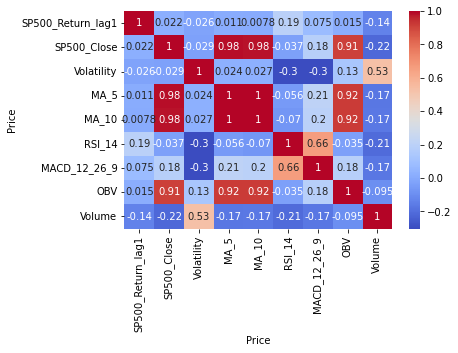

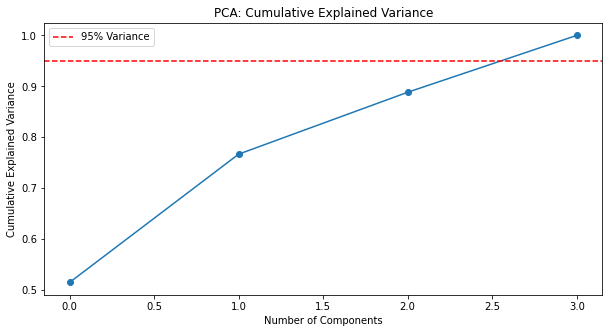

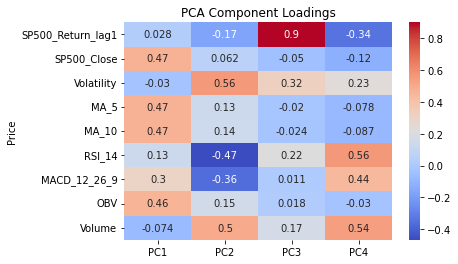

In [22]:
#Check the correlation among the features
sns.heatmap(x.corr(), annot=True, cmap="coolwarm")

# #Apply PCA
# pca = PCA(n_components=4)  
# x_pca_train_scaled = pca.fit_transform(x_train_scaled)
# x_pca_test_scaled = pca.transform(x_test_scaled)
# print("Explained variance ratio:", pca.explained_variance_ratio_)

#Visualize the usefulness of PCA
pca_full = PCA().fit(x_pca_train_scaled)
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(y=0.95, color="r", linestyle="--", label="95% Variance")
plt.title("PCA: Cumulative Explained Variance")
plt.legend()
plt.show()

loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2", "PC3", "PC4"],
    index=x.columns
)
sns.heatmap(loadings, annot=True, cmap="coolwarm")
plt.title("PCA Component Loadings")
plt.show()



## Backtesting Strategy I

Here we implement a simple strategy to test the model based on GP and PCA. We take a **Long Position** when the predicted return is positive and a **Short Position** when the predicted return is negative. Thereafter, we generate a cumulative sum of the returns over the testing period by summing up our positions and compare them with the cumulative returns from the market. The cumulative returns from the market are calculated using a simple buy and hold approach.


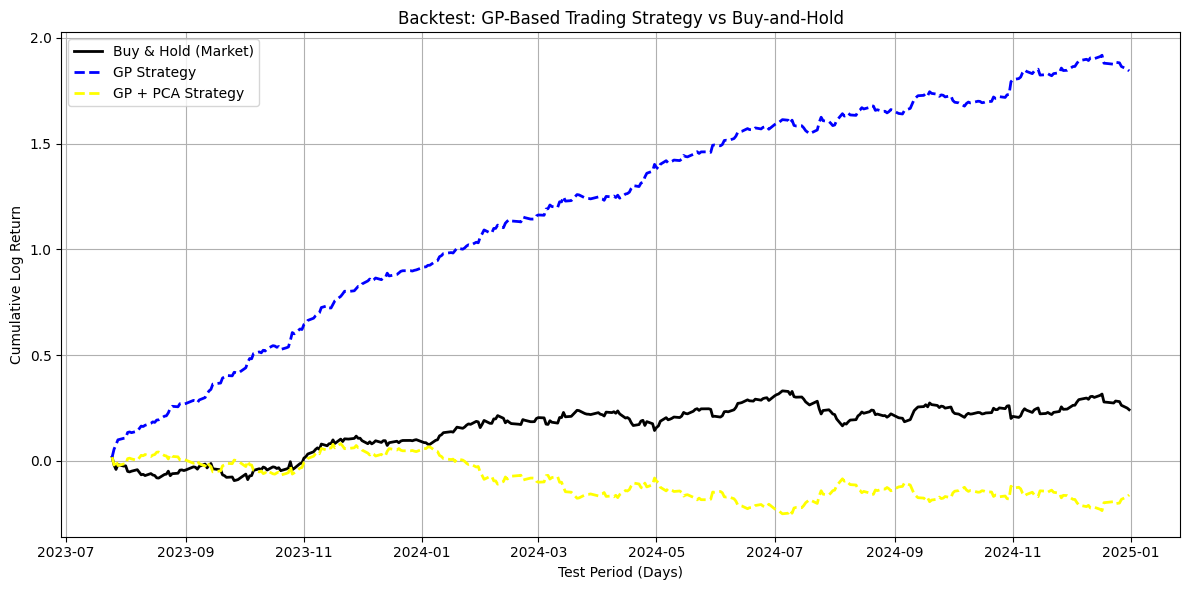

In [22]:
positions_gp = np.where(y_pred_gp > 0, 1, -1)  #if positive then +1 else -1
positions_pca = np.where(y_pred_pca > 0, 1, -1)  #Same for the gp + PCA model
strategy_return_gp = positions_gp * y_test    #multiply the positions with the actual returns
strategy_return_pca = positions_pca * y_test #Same for the gp + PCA model
 
strategy_cumulative_gp = np.cumsum(strategy_return_gp)  #cumulative return using the GP model
strategy_cumulative_pca = np.cumsum(strategy_return_pca) #Same for the gp + PCA model
market_cumulative = np.cumsum(y_test) #cumulative returns of the market


#visualize the strategy
plt.figure(figsize=(12, 6))
plt.plot(market_cumulative, label='Buy & Hold (Market)', color='black', linewidth=2)
plt.plot(strategy_cumulative_gp, label='GP Strategy', color='blue', linestyle='--', linewidth=2)
plt.plot(strategy_cumulative_pca, label='GP + PCA Strategy', color='yellow', linestyle='--', linewidth=2)
plt.title("Backtest: GP-Based Trading Strategy vs Buy-and-Hold")
plt.xlabel("Test Period (Days)")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Backtesting Strategy II

In this strategy, we adopt a Bayesian approach to making the call on the position. The **Long/Short** position is not just a binary digit but rather a risk adjusted value. The risk associated to a trade call at any time is directly protional to the uncertainty or the standard deviation in the predicted returns. Thus, we will make a stronger **Buy** call if the uncertainty is small and vice versa.

We will also filter out the weakest x % of calls and make trades only when the signals are strong. Furthermore, we also include the total cost of transactions to be closer to a real life trading scenario.

The performance metric **Sharpe Ratio** will help us in identifying that the returns provided by the strategy are actually due to the goodness of the strategy and not due to sheer luck. Another metric **Maximum Drawdown** quantifies the steepest decline in the investment from high to low within a time period. This metric indicates how much volatility is associated to a specific stock or portfolio.

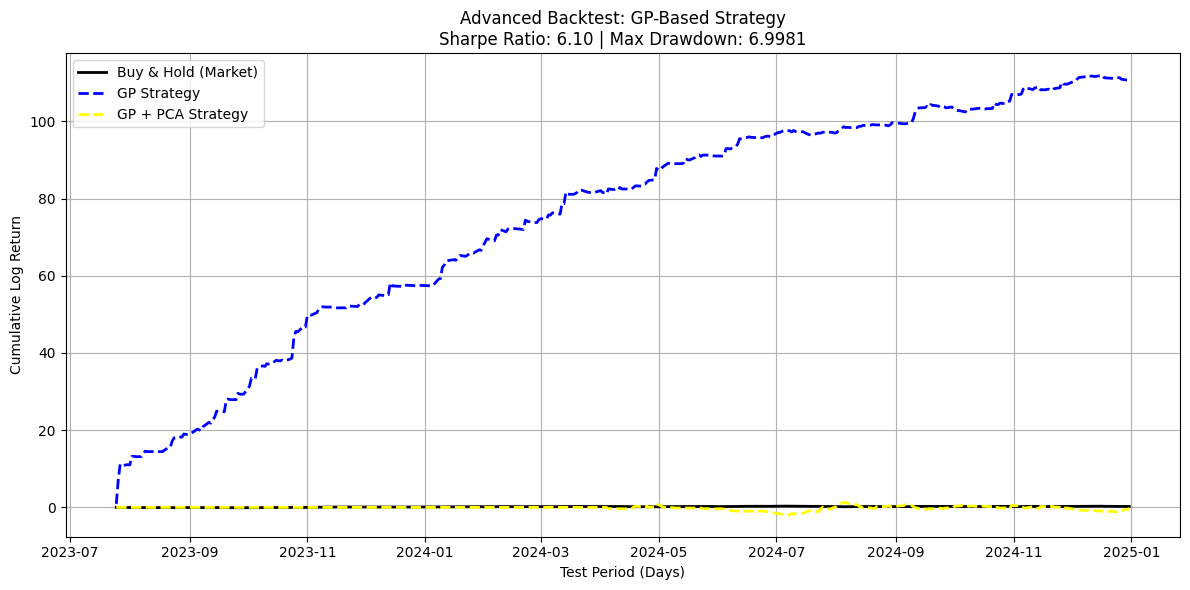

In [25]:
stability_constant = 1e-6  #a small constant to avoid division by zero in risk adjusted positions
transaction_cost = 0.002 #assume a non-zero cost of 0.2 percent associated to every transaction
threshold = np.percentile(np.abs(y_pred_gp), 25) #remove the bottom 25 percent of the positions

#define the postions adjusted with the risk/standard deviation
positions_unfiltered_gp = y_pred_gp / (y_std_gp**2 + stability_constant)
positions_unfiltered_pca = y_pred_pca / (y_std_pca**2 + stability_constant)
#apply the threshold to remove the bottom percentile of signals
positions_filtered_gp = np.where(np.abs(y_pred_gp) > threshold, positions_unfiltered_gp, 0)
positions_filtered_pca = np.where(np.abs(y_pred_pca) > threshold, positions_unfiltered_pca, 0)

transaction_cost_total_gp = transaction_cost * np.abs(np.diff(positions_filtered_gp, prepend=0))
transaction_cost_total_pca = transaction_cost * np.abs(np.diff(positions_filtered_pca, prepend=0))

#compute the returns with this strategy and subtract the total transaction cost
strategy_return_gp = positions_filtered_gp * y_test - transaction_cost_total_gp
strategy_return_pca = positions_filtered_pca * y_test - transaction_cost_total_pca

strategy_cumulative_gp = np.cumsum(strategy_return_gp)  #cumulative return using the GP model
strategy_cumulative_pca = np.cumsum(strategy_return_pca)  #for the PCA + gp case
market_cumulative = np.cumsum(y_test) #cumulative returns of the market

#compute sharpe ratio and maximum drawdown
sharpe_ratio_gp = np.mean(strategy_return_gp) / (np.std(strategy_return_gp) + stability_constant) * np.sqrt(252)
sharpe_ratio_pca = np.mean(strategy_return_pca) / (np.std(strategy_return_pca) + stability_constant) * np.sqrt(252)

rolling_max_gp = np.maximum.accumulate(strategy_return_gp)
drawdown_gp = rolling_max_gp - strategy_return_gp
max_drawdown_gp = np.max(drawdown_gp)

rolling_max_pca = np.maximum.accumulate(strategy_return_pca)
drawdown_pca = rolling_max_pca - strategy_return_pca
max_drawdown_pca = np.max(drawdown_pca)


#visualize the strategy
plt.figure(figsize=(12, 6))
plt.plot(market_cumulative, label='Buy & Hold (Market)', color='black', linewidth=2)
plt.plot(strategy_cumulative_gp, label='GP Strategy', color='blue', linestyle='--', linewidth=2)
plt.plot(strategy_cumulative_pca, label='GP + PCA Strategy', color='yellow', linestyle='--', linewidth=2)
plt.title(f"Advanced Backtest: GP-Based Strategy\nSharpe Ratio: {sharpe_ratio_gp:.2f} | Max Drawdown: {max_drawdown_gp:.4f}")
plt.xlabel("Test Period (Days)")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()